In [1]:
import pandas as pd
import numpy as np
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
import pyomo.util.infeasible as infeas
from idaes.core.util.model_statistics import *
import matplotlib.pyplot as plt
from truck_pipe_cost_functions import truck_costing, pipe_costing
from watertap3.utils.post_processing import get_results_table

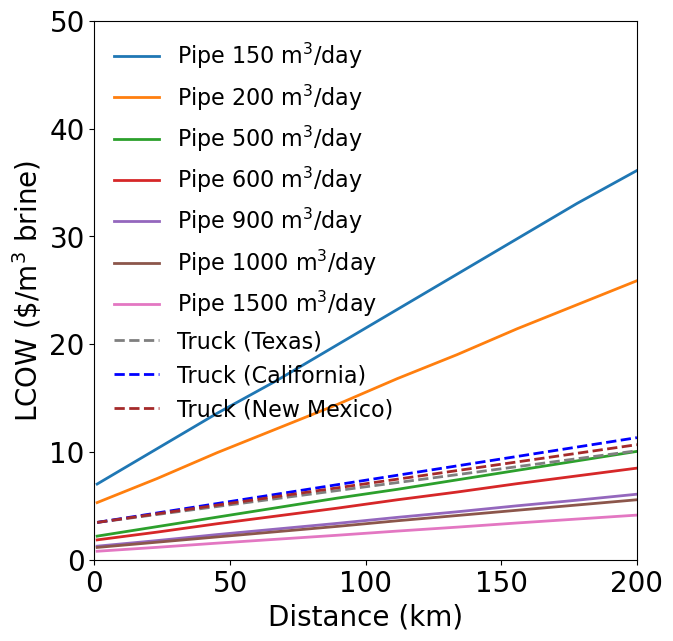

In [2]:
distance_input = np.linspace(1,200,10)
volume_input = [150,200,500,600,900,1000,1500]
output_pipe = []
output_truck_TX =[]
output_truck_CA =[]
output_truck_NM =[]

for d in distance_input:
    cost_truck_TX = truck_costing(d,wacc=0.1)
    cost_truck_CA = truck_costing(d,state='CA',wacc=0.1)
    cost_truck_NM = truck_costing(d,state='NM',wacc=0.1)
    output_truck_TX.append(cost_truck_TX)
    output_truck_CA.append(cost_truck_CA)
    output_truck_NM.append(cost_truck_NM)

for vol in volume_input:
    output_pipe_row = []
    for d in distance_input:
        cost_pipe = pipe_costing(vol,d,pump_power=20,pumping_velocity=2.7,hour_storage = 6)
        output_pipe_row.append(cost_pipe)
    output_pipe.append(output_pipe_row)

fig, ax = plt.subplots(figsize = (7,7))

for i in range(0,len(volume_input)):
    ax.plot(distance_input,output_pipe[i],label='Pipe '+ str(volume_input[i]) + r' ${\rm m^3}$/day',linewidth=2)
ax.plot(distance_input,output_truck_TX,label = 'Truck (Texas)',linestyle= '--',linewidth=2)
ax.plot(distance_input,output_truck_CA,label = 'Truck (California)',linestyle= '--',color='blue',linewidth=2)
ax.plot(distance_input,output_truck_NM,label = 'Truck (New Mexico)',linestyle= '--',color='brown',linewidth=2)
ax.legend(fontsize = 16,frameon=False)

ax.set_xlabel("Distance (km)",fontsize = 20)
ax.set_ylabel(r'LCOW (\$/m${^3}$ brine)',fontsize = 20)
ax.set_xlim([0,200])
ax.set_ylim([0,50])

ax.tick_params(axis='both', which='major', labelsize=20)

In [3]:
a = 40073.42661387725
b = 0.866701037568153
flow_in = 4.5*22.82
a*flow_in ** b

2219473.7752948166

In [4]:
# Pumping velocity sensitivity
print(pipe_costing(4.5*10*3600*24,10,pumping_velocity=5,pump_power=20))
print(pipe_costing(0.0015*3600*24,10,pumping_velocity=1.5,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=1.5,pump_power=20))

print(pipe_costing(0.0015*3600*24,10,pumping_velocity=3,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=40))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=10,pump_power=20))


0.01146495409277592
8.63027740750741
0.05443473248960341
9.709572082145057
0.04653253589757084
0.04659251809843447
0.029606227961637758


In [7]:
0.1/0.0438

2.2831050228310503

In [6]:
# Pumping velocity and capacity sensitivity
vol_list = [0.0015,0.015,0.05,0.15,1.5,4.5]
velocity_list = [1.5,2,2.5,3,3.5]
lcow = np.zeros(shape=(len(vol_list),len(velocity_list)))
for i in range(0,len(vol_list)):
    for j in range(0,len(velocity_list)):
         lcow[i,j] = pipe_costing(vol_list[i]*3600*24,10,pumping_velocity=velocity_list[j],pump_power=20)

lcow

array([[ 8.63027741,  8.80091339,  9.24801547,  9.70957208, 10.68074967],
       [ 1.08501092,  1.05293311,  1.0569034 ,  1.06681972,  1.080357  ],
       [ 0.43952966,  0.41741632,  0.40315343,  0.40056578,  0.39297083],
       [ 0.22418324,  0.20717182,  0.19639039,  0.18886267,  0.18576812],
       [ 0.08944909,  0.07720527,  0.06967715,  0.06455079,  0.0608192 ],
       [ 0.05443473,  0.05443473,  0.05118926,  0.04653254,  0.04316594]])

In [5]:
# Pump power

print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=40))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=500))

pump_power = 40 # kW
N = 1
electricity =  (N+1)*pump_power
electricity_rate = 0.06 #$/kwh
days_operation = 350
total_electricity_cost = electricity_rate * electricity *  days_operation * 24

total_electricity_cost

0.04653253589757084
0.04659251809843447
0.04791859053383311


40320.0

In [6]:
# Pipe diameter
pipe_csa = 4.5/3
pipe_diameter = 2 * (pipe_csa/np.pi)**0.5
print(pipe_diameter*39.3701) # m to inches

print(pipe_costing(45*3600*24, 10, pumping_velocity=3, pump_power=20))

54.4085568564057
0.01146495409277592


In [7]:
# Calculating the range of pump power to find the average pump power which is fixed in the transport function
def pump_power(flow_in, lift_height):
    flow_in_gpm = flow_in*1.585*1e4 #m3/s to gpm
    lift_height_ft = lift_height*3.28084  # m to ft
    return (0.746 * flow_in_gpm * lift_height_ft/ (3960 * 0.9 * 0.9)) 

print(pump_power(4.5,10))


544.2337295735128


In [16]:
wacc = 0.05
plant_lifetime_yrs = 30
crf = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)
plant_utilization = 350/365

In [14]:
3/100*(10870+8855)/0.1

5917.5

In [17]:
23532/crf*plant_utilization

346878.3045140067

In [31]:
76960*(480/(560))**0.65

69622.50511792739

In [24]:
0.1*2000000*(560*3/9400)**0.65

406.9934552055201

In [13]:
tot_cost = 2000000*(480/9400)*0.65
per_year = tot_cost*0.1 #/(350/365)
per_year

6638.297872340427

In [10]:
tot_cost = 1000000*(4.5*3600*24/9400)**0.65
per_year = tot_cost*0.065
per_year

730638.1052073875

In [6]:
44**0.72093

2.7167089252275467

In [13]:
a = 0.00344
b = 0.72093
flow = 4.5 #m3/s
storage_duration = 24 #h
storage_capacity = storage_duration*flow*3600 #convert to m3/h
storage_tank_capital_cost = a*storage_capacity**b

storage_tank_capital_cost

36843407.74974399

In [11]:
4.5*3600*24

388800.0

In [16]:
storage_capacity

388800.0

In [5]:
0.1*13220*(0.206693**1.05)

252.53612508349474

In [33]:
0.1*1322*(24**0.8)

1680.3527014398362

In [13]:
pipe_costing(0.158987*40000,50)

0.6071552481475904

In [4]:
# Checking costs from Zhou and Tol 2005
# Gruen 78 km pipeline, 75 million m3 per year, 300 m elevation. Estimate 25-34 cent/m3
print('LCOW',pipe_costing(75e6/365,78,elev_gain=300,hour_storage = 24))
# Uche 900 km, 1000 million m3 per year, 36 cent/m3
print('LCOW',pipe_costing(1000e6/365,900,elev_gain = 10,hour_storage = 24))
# Hahnemann 550 km, 1800 million m3 per year, 750 elevation. Estimate 74 cent/m3. This is an aquaduct
print('LCOW',pipe_costing(1800e6/365,550,elev_gain=750,hour_storage = 24))

print('LCOW',pipe_costing(100e6/365,280,elev_gain=320,hour_storage = 24))


pipe diameter (inch): 39.55378454686265
LCOW 0.27484003036936866
15.767214633203627
pipe diameter (inch): 63.0
LCOW 0.4690980174698058
28.380986339766533
pipe diameter (inch): 63.0
LCOW 0.172528698654626
pipe diameter (inch): 45.672776311199215
LCOW 0.8319838291817121


In [15]:
pipe_costing(75e6/365,78,elev_gain=300)

0.2546717257428119

In [20]:
pipe_costing(500,100*1.6)

8.9841550718874

In [18]:
pipe_costing()

2220.0